<a href="https://colab.research.google.com/github/calmrocks/master-machine-learning-engineer/blob/main/BasicModels/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Case Study: Forecasting Energy Demand Using Time-Series Analysis

In this case study, we demonstrate how to apply time-series forecasting techniques to predict energy demand using the **Electricity Load Diagrams 2011** dataset, a popular open-source dataset. We will explore the steps to prepare the data, analyze its trends and seasonality, and build a forecasting model using SARIMA and LSTM.

### Dataset Overview

The Electricity Load Diagrams 2011 dataset contains hourly electrical load data from a Portuguese electricity provider. The data spans a full year, making it suitable for exploring trends, seasonality, and short-term variations.

#### Key Features:
- **Datetime**: The timestamp for each observation.
- **Load (kW)**: The hourly electricity consumption.

The dataset is available for download [here](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams2011).

### Step 1: Data Preparation

Before building a model, we need to load, clean, and preprocess the data.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv("LD2011_2011.txt", sep=";", index_col=0, parse_dates=True)

# Select a single household's data for simplicity
household_data = data.iloc[:, 0]  # Selecting the first column
household_data = household_data.resample('H').mean()  # Resample to hourly data

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(household_data, label="Hourly Energy Consumption")
plt.title("Hourly Energy Consumption (2011)")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kW)")
plt.legend()
plt.show()

### Step 2: Exploratory Data Analysis

#### Decomposition of Time-Series
Using Seasonal-Trend decomposition (STL) to separate the series into trend, seasonality, and residual components.

In [ ]:
from statsmodels.tsa.seasonal import STL

# Perform STL decomposition
stl = STL(household_data, seasonal=24)  # 24-hour daily seasonality
result = stl.fit()

# Plot components
result.plot()
plt.show()

### Step 3: Model Building



### Autoregressive (AR) Model in Time Series Analysis

#### Overview
An Autoregressive (AR) model is one of the fundamental models in time series analysis. It predicts future values based on past values, assuming that future values have a linear dependency on previous observations.

#### Mathematical Representation
An AR(p) model of order p is represented as:

$y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2} + ... + \phi_py_{t-p} + \epsilon_t$

Where:
- $y_t$ is the value at time t
- $c$ is a constant (intercept)
- $\phi_1, \phi_2, ..., \phi_p$ are the parameters (coefficients) of the model
- $\epsilon_t$ is white noise (random error)
- p is the order of the AR model

#### Key Characteristics
1. **Stationarity**: AR models assume the time series is stationary (constant mean and variance over time)
2. **Order Selection**: The order p determines how many past values are used for prediction
3. **Autocorrelation**: Based on the correlation between observations at different time lags

#### Common Applications
- Financial time series forecasting
- Economic indicators prediction
- Weather forecasting
- Signal processing

#### Model Selection and Diagnostics
- AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) for order selection
- Residual analysis for model validation
- ACF (Autocorrelation Function) plots for checking model adequacy

In the following code, we'll demonstrate how to:
1. Generate AR(1) time series data
2. Fit an AR model
3. Make predictions
4. Evaluate model performance
5. Visualize results

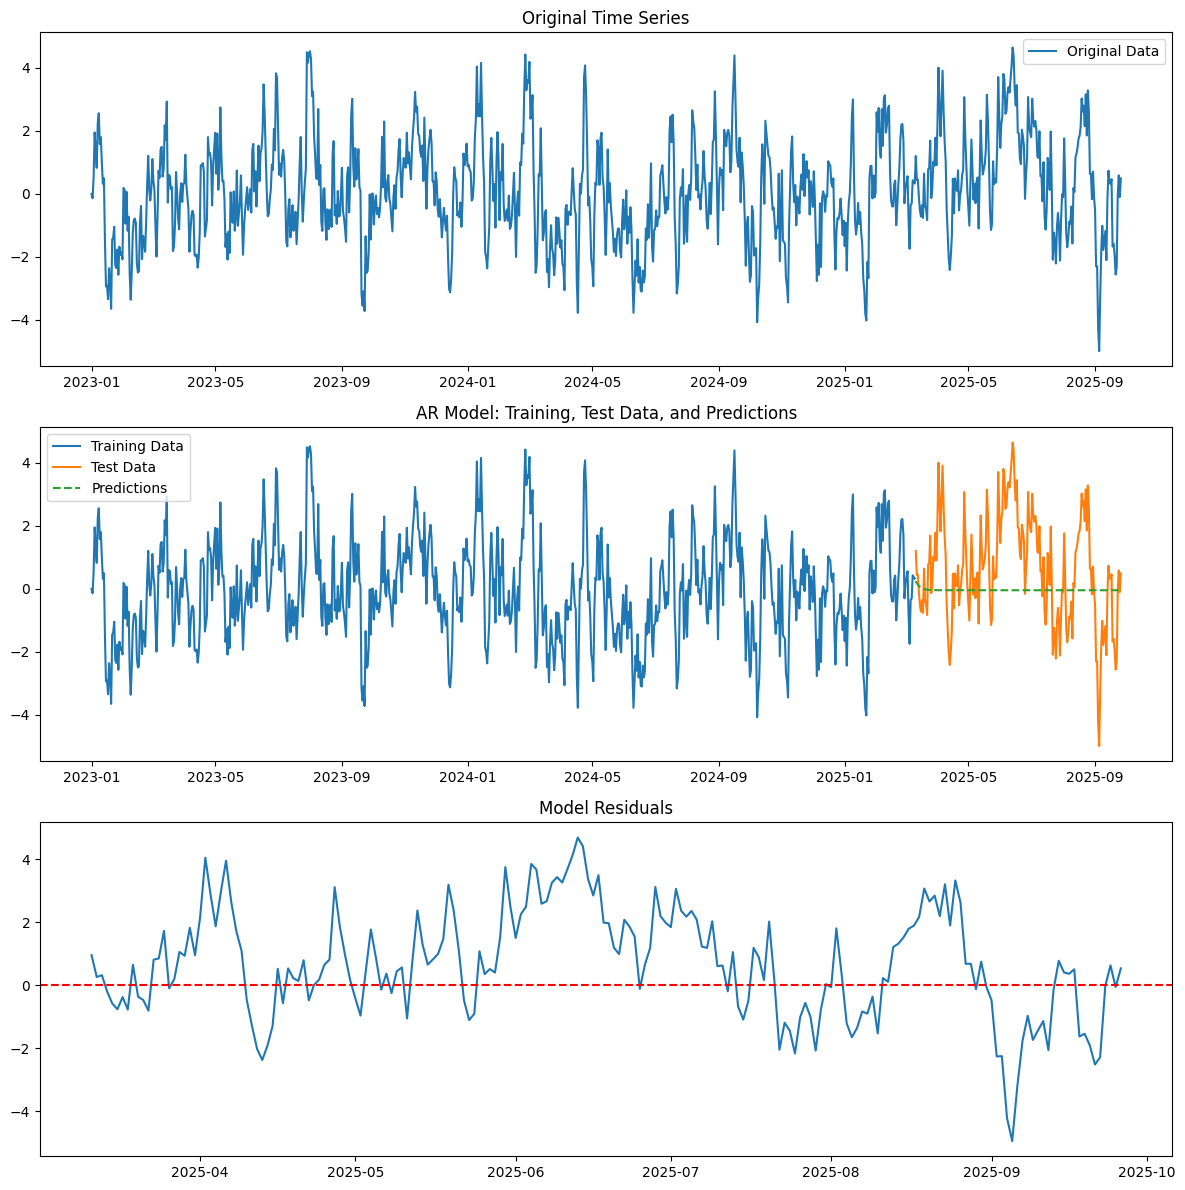


Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  800
Model:                     AutoReg(1)   Log Likelihood               -1119.998
Method:               Conditional MLE   S.D. of innovations              0.983
Date:                Sun, 02 Feb 2025   AIC                           2245.996
Time:                        19:28:26   BIC                           2260.046
Sample:                    01-02-2023   HQIC                          2251.394
                         - 03-10-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0095      0.035     -0.272      0.786      -0.078       0.059
y.L1           0.7794      0.022     35.156      0.000       0.736       0.823
                                    

<Figure size 1000x400 with 0 Axes>

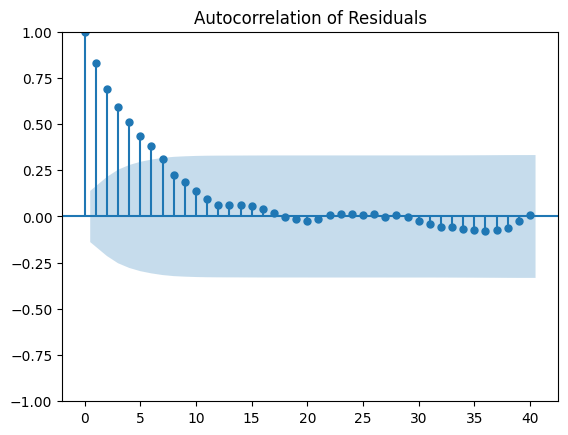

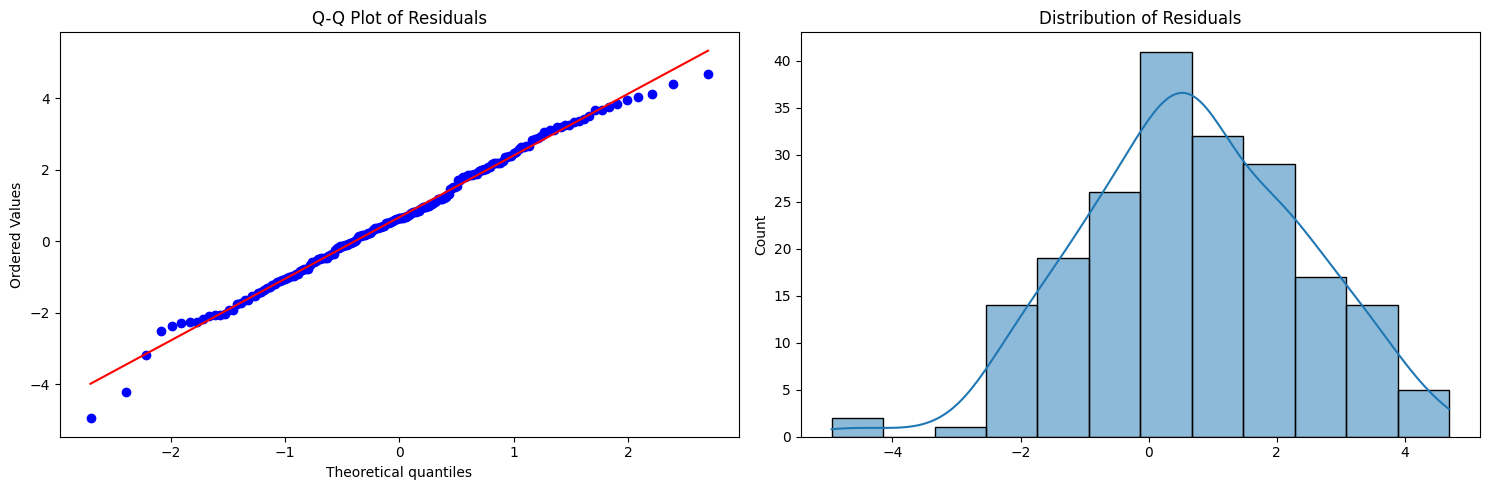

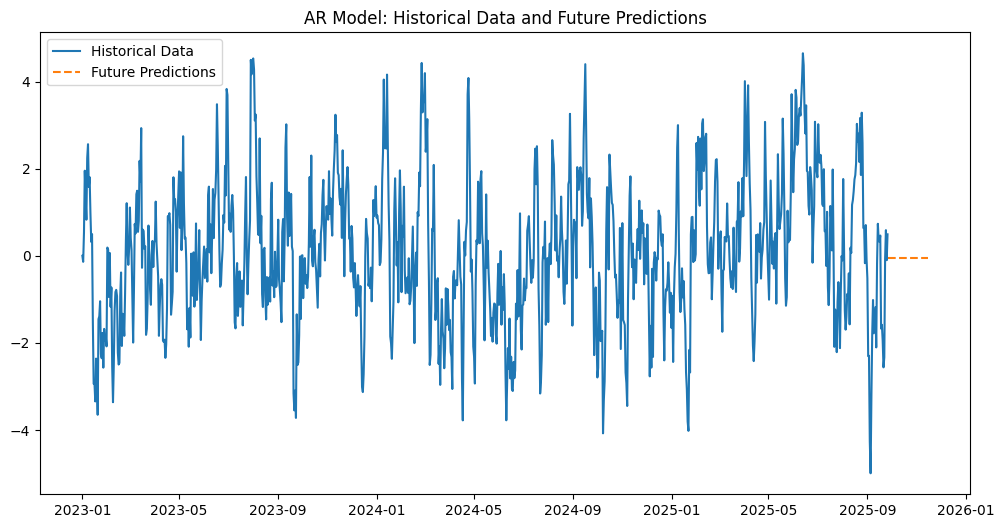

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# 1. Generate synthetic AR(1) time series data
def generate_ar_series(n_samples=1000, phi=0.8):
    """
    Generate AR(1) time series: y(t) = phi * y(t-1) + epsilon
    phi: AR coefficient
    epsilon: white noise
    """
    epsilon = np.random.normal(0, 1, n_samples)
    y = np.zeros(n_samples)

    # Generate AR(1) process
    for t in range(1, n_samples):
        y[t] = phi * y[t-1] + epsilon[t]

    return y

# Generate data
n_samples = 1000
ar_data = generate_ar_series(n_samples)
dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='D')
ts_data = pd.Series(ar_data, index=dates)

# 2. Split data into train and test sets
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

# 3. Fit AR model
model = AutoReg(train_data, lags=1)
ar_model = model.fit()

# 4. Make predictions
predictions = ar_model.predict(start=len(train_data),
                             end=len(ts_data)-1,
                             dynamic=False)

# 5. Visualizations
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# Plot 1: Original Time Series
axes[0].plot(ts_data, label='Original Data')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Plot 2: Train, Test, and Predictions
axes[1].plot(train_data, label='Training Data')
axes[1].plot(test_data, label='Test Data')
axes[1].plot(predictions, label='Predictions', linestyle='--')
axes[1].set_title('AR Model: Training, Test Data, and Predictions')
axes[1].legend()

# Plot 3: Residuals
residuals = test_data - predictions
axes[2].plot(residuals)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_title('Model Residuals')

plt.tight_layout()
plt.show()

# 6. Model Evaluation
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)

print("\nModel Summary:")
print(ar_model.summary())
print(f"\nRoot Mean Square Error: {rmse:.4f}")

# 7. Additional Analysis: ACF plot of residuals
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=40)
plt.title('Autocorrelation of Residuals')
plt.show()

# 8. Diagnostic plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot of Residuals")

# Histogram of residuals
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Residuals")

plt.tight_layout()
plt.show()

# 9. Future predictions
future_periods = 50
future_dates = pd.date_range(start=ts_data.index[-1],
                           periods=future_periods+1,
                           freq='D')[1:]
future_predictions = ar_model.predict(start=len(ts_data),
                                    end=len(ts_data)+future_periods-1,
                                    dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Historical Data')
plt.plot(future_dates, future_predictions,
         label='Future Predictions',
         linestyle='--')
plt.title('AR Model: Historical Data and Future Predictions')
plt.legend()
plt.show()

### Moving Average (MA) Models in Time Series Analysis

#### Introduction
Moving Average (MA) models are fundamental time series models that specify that the output variable depends linearly on the current and past error terms. Unlike AR models which use past values, MA models use past forecast errors in a regression-like model.

#### Mathematical Representation
An MA(q) model of order q is represented as:

$y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_q\epsilon_{t-q}$

Where:
- $y_t$ is the observed value at time t
- $\mu$ is the mean of the series
- $\theta_1, ..., \theta_q$ are the parameters of the model
- $\epsilon_t, \epsilon_{t-1}, ..., \epsilon_{t-q}$ are error terms
- q is the order of the MA model

#### Key Properties
1. **Always Stationary**: MA models are always stationary regardless of parameter values
2. **Finite Memory**: Effects of shocks last only for q periods
3. **Invertibility**: When invertible, can be converted to infinite-order AR model

#### Applications
- Financial market volatility
- Short-term forecasting
- Quality control
- Signal processing

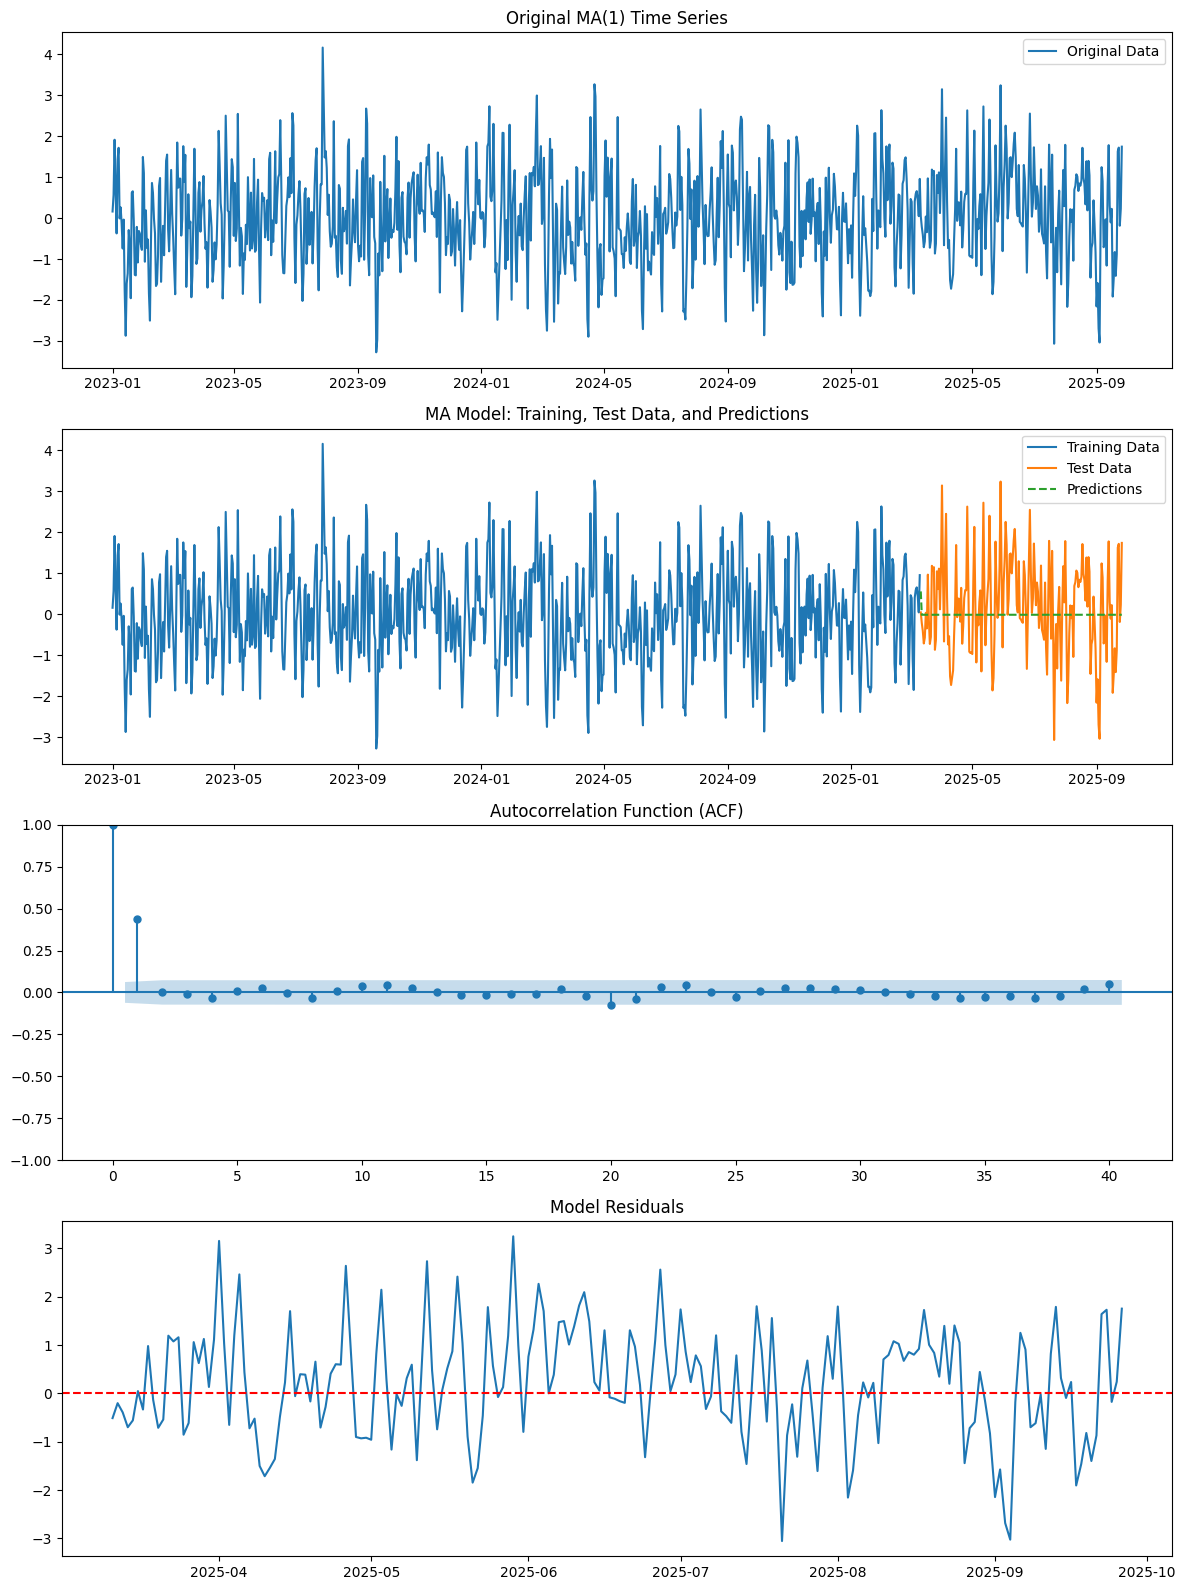


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  800
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1122.054
Date:                Sun, 02 Feb 2025   AIC                           2250.109
Time:                        19:32:43   BIC                           2264.163
Sample:                    01-01-2023   HQIC                          2255.508
                         - 03-10-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0111      0.056     -0.199      0.842      -0.121       0.099
ma.L1          0.6040      0.029     21.088      0.000       0.548       0.660
sigma2         0.9672      0.047    

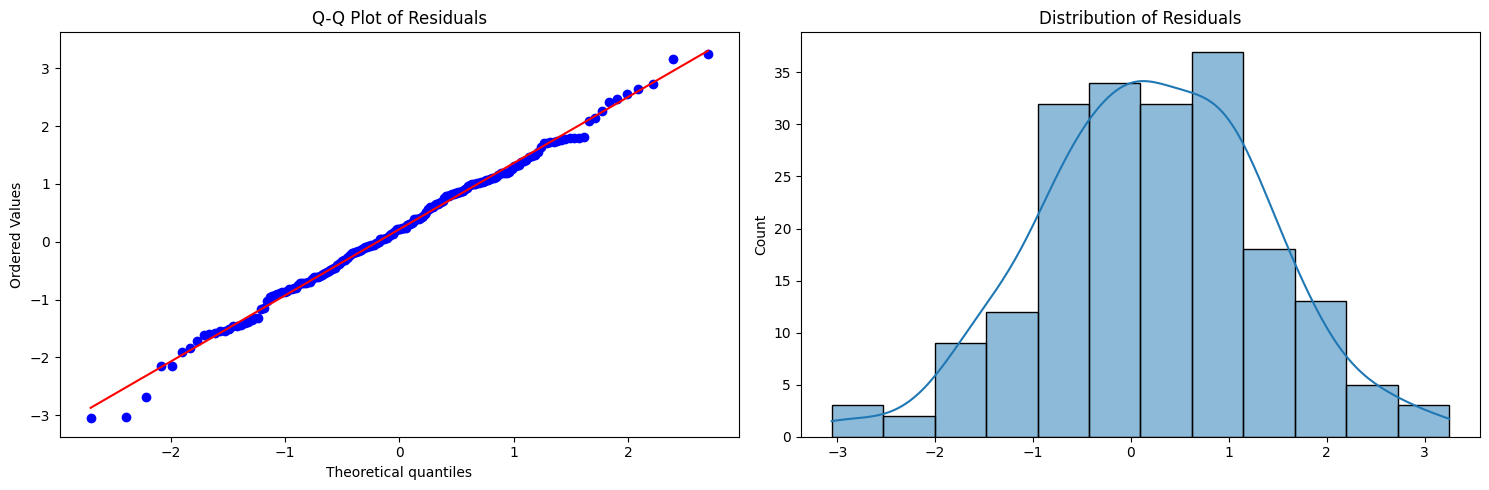

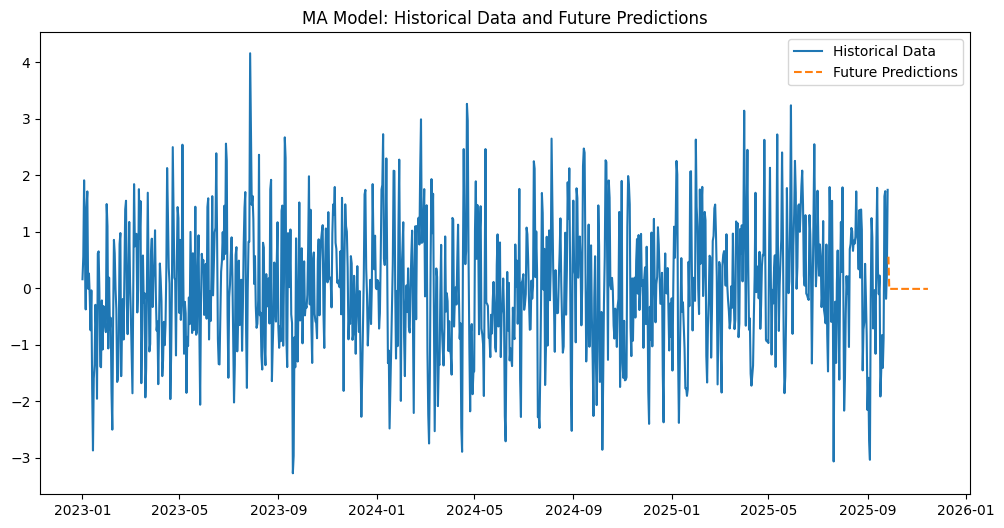

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set random seed for reproducibility
np.random.seed(42)

def generate_ma_series(n_samples=1000, theta=0.6):
    """
    Generate MA(1) time series: y(t) = ε(t) + θ*ε(t-1)
    theta: MA coefficient
    ε: white noise
    """
    epsilon = np.random.normal(0, 1, n_samples+1)
    y = np.zeros(n_samples)

    # Generate MA(1) process
    for t in range(n_samples):
        y[t] = epsilon[t+1] + theta * epsilon[t]

    return y

# Generate data
n_samples = 1000
ma_data = generate_ma_series(n_samples)
dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='D')
ts_data = pd.Series(ma_data, index=dates)

# Split data into train and test sets
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

# Fit MA model (using ARIMA(0,0,1) which is equivalent to MA(1))
model = ARIMA(train_data, order=(0,0,1))
ma_model = model.fit()

# Make predictions
predictions = ma_model.forecast(steps=len(test_data))

# Create visualizations
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

# Plot 1: Original Time Series
axes[0].plot(ts_data, label='Original Data')
axes[0].set_title('Original MA(1) Time Series')
axes[0].legend()

# Plot 2: Train, Test, and Predictions
axes[1].plot(train_data, label='Training Data')
axes[1].plot(test_data, label='Test Data')
axes[1].plot(test_data.index, predictions, label='Predictions', linestyle='--')
axes[1].set_title('MA Model: Training, Test Data, and Predictions')
axes[1].legend()

# Plot 3: ACF
plot_acf(ts_data, ax=axes[2], lags=40)
axes[2].set_title('Autocorrelation Function (ACF)')

# Plot 4: Residuals
residuals = test_data - predictions
axes[3].plot(residuals)
axes[3].axhline(y=0, color='r', linestyle='--')
axes[3].set_title('Model Residuals')

plt.tight_layout()
plt.show()

# Model evaluation
mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)

print("\nModel Summary:")
print(ma_model.summary())
print(f"\nRoot Mean Square Error: {rmse:.4f}")

# Diagnostic plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot of Residuals")

# Histogram of residuals
sns.histplot(residuals, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Residuals")

plt.tight_layout()
plt.show()

# Future predictions
future_periods = 50
future_dates = pd.date_range(start=ts_data.index[-1],
                           periods=future_periods+1,
                           freq='D')[1:]
future_predictions = ma_model.forecast(steps=future_periods)

plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Historical Data')
plt.plot(future_dates, future_predictions,
         label='Future Predictions',
         linestyle='--')
plt.title('MA Model: Historical Data and Future Predictions')
plt.legend()
plt.show()

### ARIMA (Autoregressive Integrated Moving Average) Models

#### Introduction
ARIMA is a comprehensive time series modeling framework that combines three components:
- **AR (Autoregressive)**: Uses past values to predict future values
- **I (Integrated)**: Represents differencing to make the series stationary
- **MA (Moving Average)**: Uses past forecast errors in the model

#### Mathematical Representation
ARIMA(p,d,q) model is represented as:

$(1 - \phi_1B - ... - \phi_pB^p)(1-B)^d y_t = (1 + \theta_1B + ... + \theta_qB^q)\epsilon_t$

Where:
- p: Order of AR term
- d: Degree of differencing
- q: Order of MA term
- B: Backshift operator
- $\phi_i$: AR parameters
- $\theta_i$: MA parameters
- $\epsilon_t$: White noise

#### Special Cases
1. ARIMA(p,0,0) = AR(p)
2. ARIMA(0,0,q) = MA(q)
3. ARIMA(p,0,q) = ARMA(p,q)

#### Model Selection
- Use ACF/PACF plots
- Check stationarity for determining d
- Use information criteria (AIC/BIC)
- Validate with residual analysis



Time Series Analysis

ADF Test Results for Original Series:
ADF Statistic: -1.4977
p-value: 0.5347

Is the series stationary? False


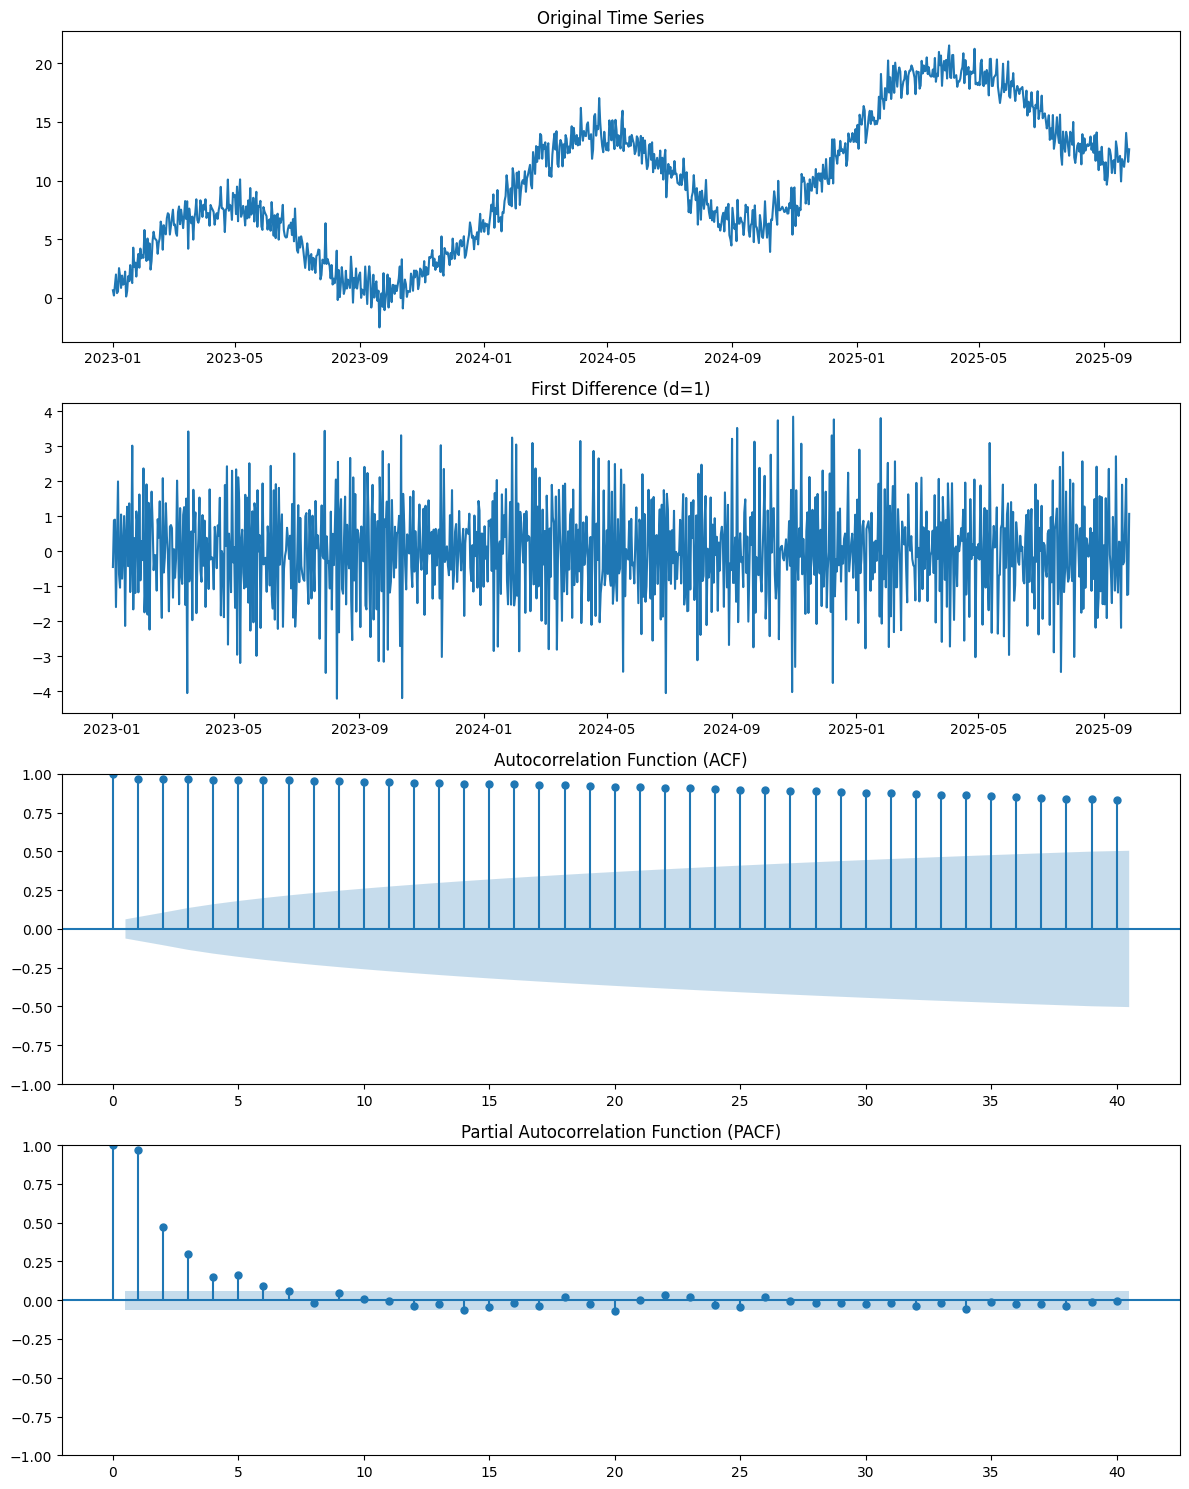


ARIMA(1, 0, 0) RMSE: 6.9638

ARIMA(0, 1, 1) RMSE: 4.4793

ARIMA(1, 1, 1) RMSE: 4.4952

ARIMA(2, 1, 2) RMSE: 4.5049


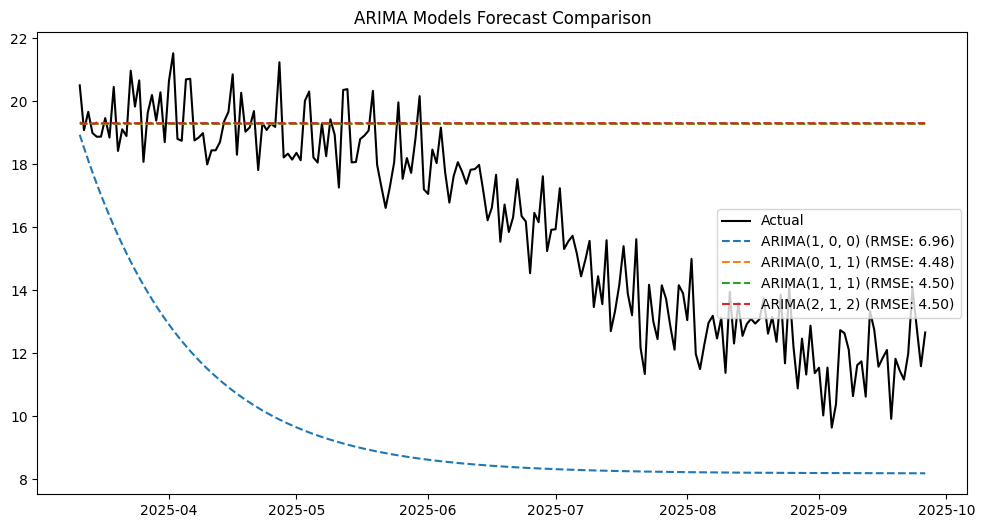


Best model: ARIMA(0, 1, 1) with RMSE: 4.4793


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set random seed for reproducibility
np.random.seed(42)

def generate_time_series(n_samples=1000):
    """
    Generate different types of time series data
    """
    # Time index
    t = np.arange(n_samples)

    # Generate components
    trend = 0.01 * t
    seasonal = 5 * np.sin(2 * np.pi * t / 365)
    noise = np.random.normal(0, 1, n_samples)
    random_walk = np.cumsum(np.random.normal(0, 0.1, n_samples))

    # Combine components
    series = trend + seasonal + random_walk + noise

    return series

def check_stationarity(series, title):
    """
    Perform ADF test and print results
    """
    result = adfuller(series)
    print(f'\nADF Test Results for {title}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    return result[1] < 0.05

def plot_series_analysis(data, dates):
    """
    Plot original series, differenced series, and ACF/PACF
    """
    fig, axes = plt.subplots(4, 1, figsize=(12, 15))

    # Original Series
    axes[0].plot(dates, data)
    axes[0].set_title('Original Time Series')

    # First Difference
    diff1 = pd.Series(data).diff().dropna()
    axes[1].plot(dates[1:], diff1)
    axes[1].set_title('First Difference (d=1)')

    # ACF
    plot_acf(data, ax=axes[2], lags=40)
    axes[2].set_title('Autocorrelation Function (ACF)')

    # PACF
    plot_pacf(data, ax=axes[3], lags=40)
    axes[3].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

def fit_and_forecast_arima(data, orders, train_size=0.8):
    """
    Fit ARIMA models with different orders and compare forecasts
    """
    # Split data into train and test
    train = data[:int(len(data)*train_size)]
    test = data[int(len(data)*train_size):]

    results = []
    for order in orders:
        # Fit model
        model = ARIMA(train, order=order)
        fitted = model.fit()

        # Make forecast
        forecast = fitted.forecast(steps=len(test))

        # Calculate RMSE
        rmse = np.sqrt(np.mean((test - forecast) ** 2))
        results.append((order, rmse, forecast))

        print(f'\nARIMA{order} RMSE: {rmse:.4f}')

    return results

# Generate data
n_samples = 1000
dates = pd.date_range(start='2023-01-01', periods=n_samples, freq='D')
data = generate_time_series(n_samples)

# Analysis
print("Time Series Analysis")
print("===================")

# Check stationarity
is_stationary = check_stationarity(data, "Original Series")
print(f"\nIs the series stationary? {is_stationary}")

# Plot analysis
plot_series_analysis(data, dates)

# Fit different ARIMA models
orders = [(1,0,0), (0,1,1), (1,1,1), (2,1,2)]
results = fit_and_forecast_arima(data, orders)

# Plot forecasts
plt.figure(figsize=(12, 6))
train_size = int(0.8 * len(data))
plt.plot(dates[train_size:], data[train_size:], label='Actual', color='black')

for (order, rmse, forecast) in results:
    plt.plot(dates[train_size:], forecast,
             label=f'ARIMA{order} (RMSE: {rmse:.2f})',
             linestyle='--')

plt.title('ARIMA Models Forecast Comparison')
plt.legend()
plt.show()

# Model diagnostics for best model
best_model = min(results, key=lambda x: x[1])
print(f"\nBest model: ARIMA{best_model[0]} with RMSE: {best_model[1]:.4f}")

#### SARIMA Model
SARIMA (Seasonal ARIMA) is well-suited for capturing both trends and seasonality.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
train = household_data[:'2011-10']
test = household_data['2011-11':]

# Fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
sarima_result = sarima_model.fit()

# Forecast
forecast = sarima_result.forecast(steps=len(test))

# Evaluate model
mse = mean_squared_error(test, forecast)
print(f"SARIMA Test MSE: {mse}")

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data", color="orange")
plt.plot(test.index, forecast, label="SARIMA Forecast", color="green")
plt.legend()
plt.show()

#### LSTM Model
Long Short-Term Memory (LSTM) networks handle non-linear patterns and long-term dependencies in time-series data.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare data for LSTM
def create_lagged_data(series, lag):
    X, y = [], []
    for i in range(len(series) - lag):
        X.append(series[i:i+lag])
        y.append(series[i+lag])
    return np.array(X), np.array(y)

# Create lagged dataset
lag = 24
X, y = create_lagged_data(household_data.values, lag)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lag, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Forecast
lstm_forecast = model.predict(X_test)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual Data", color="orange")
plt.plot(lstm_forecast, label="LSTM Forecast", color="green")
plt.legend()
plt.show()

### Step 4: Summary and Recommendations

#### Summary:
- **SARIMA**: Suitable for capturing linear trends and seasonality in time-series data.
- **LSTM**: Effective for handling non-linear patterns and long-term dependencies.

#### Recommendations:
- For simpler time-series data with clear seasonality, SARIMA provides interpretable and robust forecasts.
- For complex data with non-linear patterns or multiple seasonal cycles, LSTM offers better adaptability and accuracy.

#### Next Steps:
- Experiment with hybrid models combining SARIMA and LSTM to leverage their strengths.
- Explore advanced techniques like Prophet or Transformer-based time-series models for further improvement.